## SpatioTemporal DeepKriging

This notebook contains a demonstration of SpatioTemporal DeepKriging used to impute simulated monthly rainfall data. 
____________
First we'll load in the necessary libraries. Note that that this implementation of DeepKriging was implemented using Python v3.13. It also uses:

* pandas v2.2.3
* numpy v2.2.2
* matplotlib v3.10.0
* geopandas v1.0.1
* shapely v2.0.7
* torch v2.6.0
* scipy v1.15.1
* scikit-learn v1.6.1

In [1]:
# Base libraries
import math
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
from shapely.geometry import Point

# Deep learning libraries (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from copy import deepcopy

# Extra math functions
from scipy.special import kv, gamma
from sklearn.metrics import mean_squared_error


Now we'll load in some data. The simulated data was generated using the code in "simulate_data.Rmd". It comprises two hundred stations with monthly measurements over five years.

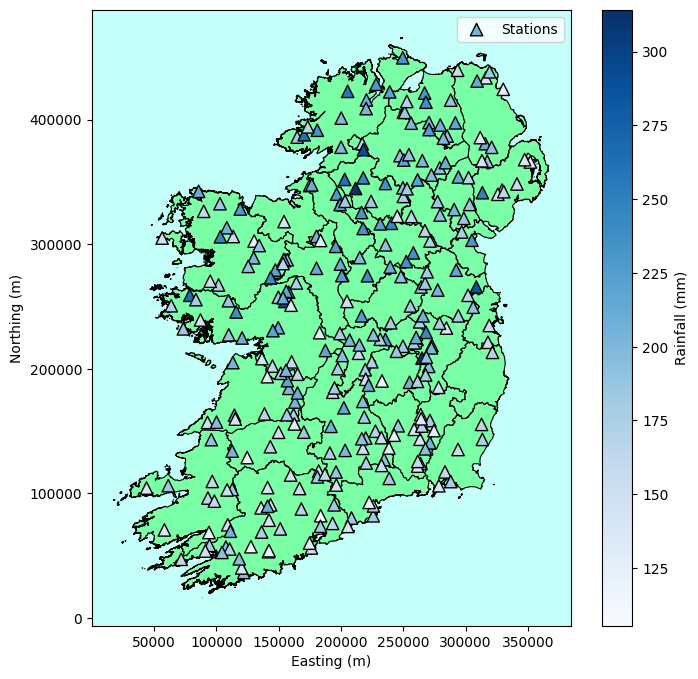

In [2]:
df = pd.read_csv('data/simulated_rainfall.csv')

# Some small adjustments
#    - order the data
#    - adjust the time index to match with python indexing
#    - remove row names (we don't need them)
df = df.sort_values(by=["t", "stno"])
df["t"] = df["t"] - 1
df = df.reset_index(drop=True)

no_times = df["t"].max() + 1
no_stations = df["stno"].nunique()

# Get spatial coordinates and normalize them
lon = df[df["t"] == 0]["east"].values
lat = df[df["t"] == 0]["north"].values
normalized_lon = (lon-min(lon))/(max(lon)-min(lon))
normalized_lat = (lat-min(lat))/(max(lat)-min(lat))
N = df.shape[0]

# Time coordinates
t = np.arange(no_times)




# Let's visualize the first month of data
# Load Ireland borders with CRS of EPSG:29903 (easting and northing)
counties = gpd.read_file("data/counties.json")
counties = counties.to_crs(epsg=29903)
stations_gdf = gpd.GeoDataFrame(
    {"geometry": gpd.points_from_xy(lon, lat)},
    crs="EPSG:29903"
)

# PLot window
fig, ax = plt.subplots(figsize=(8, 8))
counties.plot(ax=ax, edgecolor='black', facecolor='#7affa7', linewidth=0.8)
ax.set_facecolor('#c4fff9')

cmap = plt.cm.Blues

# Plot stations
sc = ax.scatter(
    [pt.x for pt in stations_gdf.geometry],
    [pt.y for pt in stations_gdf.geometry],
    edgecolors="black",
    facecolors = "red",
    marker='^', 
    s=80,
    c = df[df["t"] == 0]["y"],
    cmap = cmap,
    label="Stations",
)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Rainfall (mm)")

plt.legend()
plt.show()

Now we need to load in our mesh and create spatial and temporal basis functions. The Delaunay triangulation for the spatial mesh was generated using the fdaPDE R package developed by Amone et al (https://CRAN.R-project.org/package=fdaPDE). The mesh generation used in this case can be found in "make_mesh.Rmd".

In [3]:
## Spatial basis functions - first load in meshes

mesh1 = pd.read_csv('data/mesh_1.csv', index_col = 0)
mesh2 = pd.read_csv('data/mesh_2.csv', index_col = 0)
mesh3 = pd.read_csv('data/mesh_3.csv', index_col = 0)
mesh4 = pd.read_csv('data/mesh_4.csv', index_col = 0)
meshes = [mesh1, mesh2, mesh3, mesh4]

# Normalize the meshes
for idx, mesh in enumerate(meshes):
    meshes[idx] = meshes[idx].to_numpy()
    meshes[idx][:, 0] = (meshes[idx][:, 0] - min(lon))/(max(lon)-min(lon))
    meshes[idx][:, 1] = (meshes[idx][:, 1] - min(lat))/(max(lat)-min(lat))

# Save spatial basis functions to phi_s
phi_s = np.zeros((len(lon), sum([len(mesh) for mesh in meshes])))
basis_size = 0

# For spatial basis functions, we use a Gaussian radial basis function
# theta is a general scaling parameter
# avg_dists is the average distance between knotpoints for each mesh
# length_scales describe the rates of decay of the basis functions for each mesh
theta = 2.5
avg_dists = [12, 30, 70, 150]
length_scales = [0.5, 1, 2, 10]

# Loop over each mesh
for res in range(len(meshes)):

    # Get knots
    theta_res, length_scale = 1/avg_dists[res] * theta, length_scales[res]
    knots_x, knots_y = meshes[res][:, 0], meshes[res][:, 1]
    knots = np.column_stack((knots_x.flatten(),knots_y.flatten()))

    # For each station, calculate its distance to each knot and corresponding basis function
    for i in range(len(meshes[res])):
        d = np.linalg.norm(np.vstack((normalized_lon,normalized_lat)).T-knots[i,:],axis=1) / theta_res
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi_s[j,i + basis_size] = np.exp(-length_scale * d[j])
            else:
                phi_s[j,i + basis_size] = 0
    basis_size = basis_size + len(meshes[res])

# When the distances between knots and stations large enough, the basis functions are small and negligible
# we'll remove these to improve computation times
phi_s[phi_s < 1e-6] = 0




## Temporal basis functions

# Knots are evenly spaced in time - three resolutions
num_basis = [20, 77, 331]
temporal_knots = [np.linspace(0, no_times - 1, int(i)) for i in num_basis]

# Temporal basis functions saved to phi_t
phi_t = np.zeros((no_times, sum(num_basis)))
K = 0

# In this case we'll use Matérn radial basis functions
def matern(d, nu, l=1):
    factor = (2**(1-nu)) / gamma(nu)
    scaled_d = np.sqrt(2 * nu) * d / l
    if scaled_d == 0: # Will get NaN values if d = 0
        return 1
    return factor * (scaled_d**nu) * kv(nu, scaled_d)

# Basis functions have done well with high smoothness, ie t_nu = 4
# t_l and std_arr are scaling parameters of the distance
t_nu = 4
t_l = 0.5
std_arr = np.array([8, 5, 1])

# At each resolution get std_arr
for res in range(len(num_basis)):
    std = std_arr[res]

    # For each point in time, get its distance from each knotpoint and calculate the basis function
    for i in range(num_basis[res]):
        d = np.absolute(t-temporal_knots[res][i]) / (std**2)
        for j in range(len(d)):
            phi_t[j,i + K] = matern(d[j], t_nu, t_l)
    K = K + num_basis[res]

# Again, bring basis functions to zero when they are small at large distances
phi_t[phi_t < 1e-6] = 0

# For each observation, we need to get the spatial and temporal basis functions
# so duplicate phi_s and phi_t to reflect this
phi_s = np.tile(phi_s, (no_times, 1))
phi_t = np.repeat(phi_t, no_stations, axis=0)
phi = np.hstack((phi_s, phi_t))

# Remove columns that only have zeros
idx_zero = np.where(np.all(phi == 0, axis=0))[0]
phi = np.delete(phi, idx_zero, 1)

# Add some other covariates and normalize them
x_idx = [df.columns.get_loc('east'), df.columns.get_loc('north'), df.columns.get_loc('t')]
X = df.iloc[:, x_idx].values
normalized_X = X
for i in range(X.shape[1]):
    normalized_X[:,i] = (X[:,i]-min(X[:,i]))/(max(X[:,i])-min(X[:,i]))
N_obs = X.shape[0]

# Target values
y_idx = df.columns.get_loc('y')
y = df.iloc[:, y_idx].values

# Now we have inputs and targets for neural network
inputs = np.hstack((normalized_X, phi))
targets = y

Now that the data is setup, we just need to configure the neural network model. For the Irish rainfall data, a simpler model a small number of hidden layers was found to perform the best. The network architecture includes batch normalization and dropout layers to help fitting. A dropout rate of p_dropout = 0.1 was found to be effective.

In [4]:
def make_model(p, p_dropout):
    model = nn.Sequential(
        nn.Linear(p, 512), 
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(p_dropout),
    
        nn.Linear(512, 256), 
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(p_dropout),
    
        nn.Linear(256, 256), 
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(p_dropout),
    
        nn.Linear(256, 64), 
        nn.ReLU(),
        nn.BatchNorm1d(64),
        nn.Dropout(p_dropout),
    
        nn.Linear(64, 1)
    )
    return model

## Other hyperparameters, you want a nice balance between computation and prediction accuracy
epochs = 150
learning_rate = 1e-4
batch_size = 128
weight_decay = 1e-3

Let's train the network and see how the model does. We'll remove 10% of the observations from the data to check model performance.

In [5]:
# Convert numpy arrays to torch tensors
inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
targets_tensor = torch.tensor(targets, dtype=torch.float32).view(-1, 1)

# Split into training and validation (90% 10% split)
num_samples = inputs_tensor.size(0)
torch.manual_seed(222)
mask = torch.rand(num_samples) > 0.1
train_inputs, val_inputs = inputs_tensor[mask], inputs_tensor[~mask]
train_targets, val_targets = targets_tensor[mask], targets_tensor[~mask]

best_rmse = float('inf')
    
# Create DataLoader for batching
train_data = TensorDataset(train_inputs, train_targets)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data = TensorDataset(val_inputs, val_targets)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    
# Initialize model, loss function, and optimizer
model = make_model(p=train_inputs.shape[1], p_dropout=0.1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch+1}", flush = True)
    model.train()
    running_loss = 0.0

    for batch_idx, (inputs_batch, targets_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs_batch)
        loss = criterion(outputs, targets_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Compute RMSE for training data
    model.eval()
    with torch.no_grad():
        train_outputs = model(train_inputs)
        train_mse = mean_squared_error(train_targets.numpy(), train_outputs.numpy())
        train_rmse = np.sqrt(train_mse)

        val_outputs = model(val_inputs)
        val_mse = mean_squared_error(val_targets.numpy(), val_outputs.numpy())
        val_rmse = np.sqrt(val_mse)

    # Print RMSE for training and validation data
    print(f"Average Loss: {running_loss / len(train_loader):.4f}", flush = True)
    print(f"Training RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}", flush = True)

    if train_rmse < best_rmse:
        best_rmse = train_rmse
        checkpoint = deepcopy(model.state_dict())

# Predict final values from fitted model at best checkpoint
model.load_state_dict(checkpoint)
model.eval()

with torch.no_grad():
    val_outputs = []
    val_targets_list = []
    for val_inputs_batch, val_targets_batch in val_loader:
        outputs = model(val_inputs_batch)
        val_outputs.append(outputs)
        val_targets_list.append(val_targets_batch)
    
    val_outputs = torch.cat(val_outputs, dim=0)

Epoch 1
Average Loss: 12023.4848
Training RMSE: 108.8731, Validation RMSE: 109.1865
Epoch 2
Average Loss: 11686.0722
Training RMSE: 107.7361, Validation RMSE: 108.0204
Epoch 3
Average Loss: 11394.0147
Training RMSE: 105.9314, Validation RMSE: 106.2226
Epoch 4
Average Loss: 11092.6034
Training RMSE: 104.7886, Validation RMSE: 105.1963
Epoch 5
Average Loss: 10773.7422
Training RMSE: 102.8827, Validation RMSE: 103.3986
Epoch 6
Average Loss: 10436.0371
Training RMSE: 101.6179, Validation RMSE: 102.0797
Epoch 7
Average Loss: 10093.8202
Training RMSE: 100.8228, Validation RMSE: 101.3420
Epoch 8
Average Loss: 9737.0492
Training RMSE: 97.3918, Validation RMSE: 97.9862
Epoch 9
Average Loss: 9374.1354
Training RMSE: 95.8274, Validation RMSE: 96.3843
Epoch 10
Average Loss: 9010.3134
Training RMSE: 94.3044, Validation RMSE: 95.0266
Epoch 11
Average Loss: 8639.5920
Training RMSE: 91.8262, Validation RMSE: 92.5605
Epoch 12
Average Loss: 8281.8856
Training RMSE: 89.0762, Validation RMSE: 89.8030
Epoc

RMSE: 17.550mm
R2: 0.906


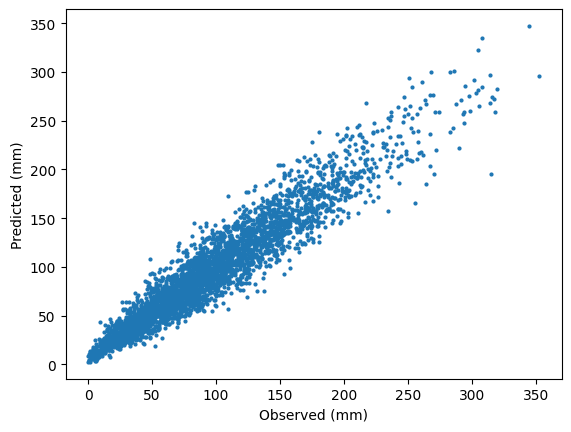

In [6]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

print(f"RMSE: {rmse(val_targets.numpy(), val_outputs.numpy()):.3f}mm", )
print(f"R2: {r_squared(val_targets.numpy(), val_outputs.numpy()):.3f}")

plt.scatter(val_targets.numpy(), val_outputs.numpy(), s=4)
plt.xlabel("Observed (mm)")
plt.ylabel("Predicted (mm)")
plt.show()

DeepKriging models are not limited to imputation. They can also be used for predicting on to a grid.

In [7]:
# Dataframe for gridpoints (We'll just pick a time point in middle of simulated data)
normalized_east = np.linspace(-0.08, 1.04, 100)
normalized_north = np.linspace(-0.045, 1.035, 100)
normalized_t = (60-min(X[:, 2]))/(max(X[:, 2])-min(X[:, 2]))

xx, yy = np.meshgrid(normalized_east, normalized_north)
df_grid = pd.DataFrame({"east": xx.ravel(), "north": yy.ravel()})
df_grid["t"] = normalized_t

# Covariates
x_idx_grid = [df_grid.columns.get_loc('east'), df_grid.columns.get_loc('north'), df_grid.columns.get_loc('t')]
X_grid = df_grid.iloc[:, x_idx_grid].values

# Calculate spatial and temporal basis functions
phi_s_grid = np.zeros((df_grid.shape[0], sum([len(mesh) for mesh in meshes])))
basis_size = 0
for res in range(len(meshes)):
    theta_res, length_scale = 1/avg_dists[res] * theta, length_scales[res]
    knots_x, knots_y = meshes[res][:, 0], meshes[res][:, 1]
    knots = np.column_stack((knots_x.flatten(),knots_y.flatten()))

    for i in range(len(meshes[res])):
        d = np.linalg.norm(np.vstack((df_grid["east"].values,df_grid["north"].values)).T-knots[i,:],axis=1) / theta_res
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi_s_grid[j,i + basis_size] = np.exp(-length_scale * d[j])
            else:
                phi_s_grid[j,i + basis_size] = 0
    basis_size = basis_size + len(meshes[res])
phi_s_grid[phi_s_grid < 1e-6] = 0

phi_t_grid = np.zeros((1, sum(num_basis)))
K = 0
for res in range(len(num_basis)):
    std = std_arr[res]
    for i in range(num_basis[res]):
        d = np.absolute(normalized_t-temporal_knots[res][i]) / (std**2)
        phi_t_grid[0, i + K] = matern(d, t_nu, t_l)
    K = K + num_basis[res]
phi_t_grid[phi_t_grid < 1e-6] = 0

phi_t_grid = np.repeat(phi_t_grid, df_grid.shape[0], axis=0)
phi_grid = np.hstack((phi_s_grid, phi_t_grid))
phi_grid = np.delete(phi_grid, idx_zero, 1)

inputs_grid = np.hstack((X_grid, phi_grid))
inputs_tensor_grid = torch.tensor(inputs_grid, dtype=torch.float32)

with torch.no_grad():
    df_grid["y"] = model(inputs_tensor_grid).numpy()

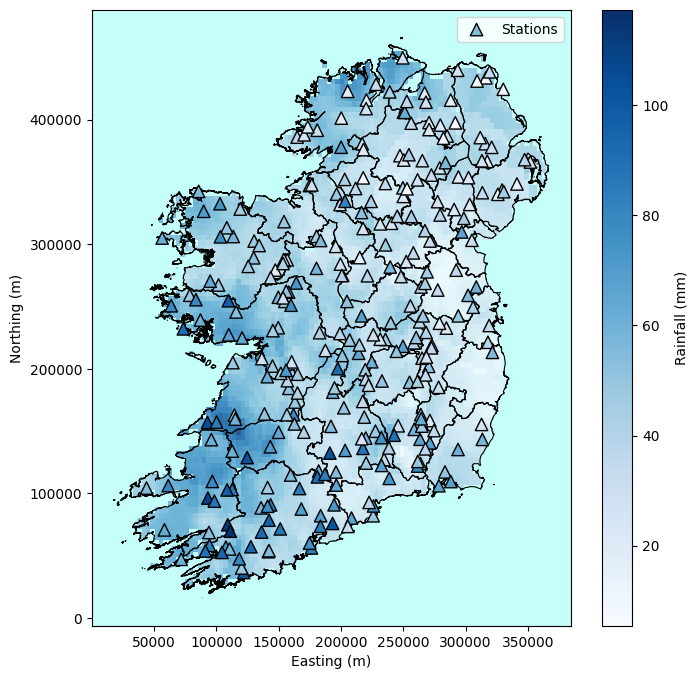

In [8]:
# Plotting - this may be slow for higher resolutions
east = normalized_east * (max(lon) - min(lon)) + min(lon)
north = normalized_north * (max(lat) - min(lat)) + min(lat)
xx_plot, yy_plot = np.meshgrid(east, north)

fig, ax = plt.subplots(figsize=(8, 8))
counties.plot(ax=ax, edgecolor='black', facecolor='None', linewidth=0.8, zorder = 2)
ax.set_facecolor('#c4fff9')

cmap = plt.cm.Blues

# Plot grid
extent = [east.min(), east.max(), 
          north.min(), north.max()]
z = df_grid["y"].values.reshape(len(east), len(north))

# This code is just for plotting only on the island (change z for z_masked in plot)
# but computationally it's pretty slow
gdf = gpd.GeoDataFrame(
    {'geometry': [Point(x, y) for x, y in zip(xx_plot.ravel(), yy_plot.ravel())]},
    crs=counties.crs
)

simple_counties = counties.copy()
simple_counties["geometry"] = simple_counties.geometry.simplify(tolerance=1500, preserve_topology=True)
gdf["inland"] = gdf.geometry.within(simple_counties.geometry.union_all())
mask = gdf["inland"].values.reshape(xx_plot.shape)
z_masked = np.ma.masked_where(~mask, z)

im = ax.imshow(
    z_masked,
    # z,
    extent=extent,
    origin="lower",
    cmap=cmap,
    alpha=0.8,
    zorder = 1
)

# Plot stations
sc = ax.scatter(
    [pt.x for pt in stations_gdf.geometry],
    [pt.y for pt in stations_gdf.geometry],
    edgecolors="black",
    facecolors = "red",
    marker='^', 
    s=80,
    c = df[df["t"] == 60]["y"],
    cmap = cmap,
    label="Stations",
    zorder = 3
)

ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Rainfall (mm)")

plt.legend()
plt.show()
